# Table of contents

1. Empirical Frequencies in the PILE dataset
2. GPT-Neo-125M estimated probabilities

We will start by analizing some marginals and see how the model relates to that.

## Elastic Search

In [124]:
from elasticsearch import Elasticsearch
from functools import partial

# Create an elastic search engine
es = Elasticsearch(
     cloud_id="lm-datasets:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDk1N2U5ODIwZDUxNTQ0YWViMjk0MmQwNzI1NjE0OTQ2JDhkN2M0OWMyZDEzMTRiNmM4NDNhNGEwN2U4NDE5NjRl",
     api_key="T2w5Vl9ZTUIzVzE5dTlBblUtRlo6MHNBYWxhbHVTeGFodUpUOWIybkNNZw==",
     retry_on_timeout=True,
     http_compress=True,
)

# Syntactic sugar to avoid repeating index and keyword arguments
search = partial(
    es.search,
    
    index="re_pile",
    track_total_hits=True,
)


def scroll(query, size, scroll):
    data = search(query=query, size=size, scroll=scroll)
    print("Total documents found", data["hits"]["total"])

    sid = data["_scroll_id"]
    scroll_size = len(data["hits"]["hits"])

    
    while scroll_size > 0:
        print("Processing", scroll_size, "documents")
        
        yield data["hits"]["hits"]
        
        data = es.scroll(scroll_id=sid, scroll="2m")
        sid = data["_scroll_id"]

        scroll_size = len(data["hits"]["hits"])

    es.clear_scroll(scroll_id=sid)
    

def to_json(data, filepath, mode="a"):
    import json
    data = data if isinstance(data, (list, tuple)) else [data]
    data = [json.dumps(l, sort_keys=True) for l in data]
    
    with open(filepath, mode=mode) as f:
        f.writelines(data)
        

## Verify queries are encoded as single tokens

This verification is necessary because the current method does not consider contiguous sequences of tokens.

In [149]:
## Auxiliar function
def check_marginal_queries(terms_A, tokenizer, add_special_tokens=False):
    terms_ids = tokenizer(terms_A, add_special_tokens=add_special_tokens).input_ids
    assert len(terms_ids) == len(terms_A.split()), f"Terms: '{terms_A}' map to more than one token_id each: {terms_ids}"
    

def check_queries(terms_A, terms_B, tokenizer, add_special_tokens=False):
    for terms in (terms_A, terms_B):
        terms_ids = tokenizer(terms, add_special_tokens=add_special_tokens).input_ids
        assert len(terms_ids) == len(terms.split()), f"Terms: '{terms}' map to more than one token_id each: {terms_ids}"
    

In [237]:
from importance_sampler import ImportanceSampler

DEVICE = "cuda"
MAX_NUM_TOKENS = 15
MODEL_NAME = "EleutherAI/gpt-neo-125M"
NUM_SEQUENCES = 250
SEED = 20230126

sampler = ImportanceSampler(
    model_name=MODEL_NAME,
    device=DEVICE,
)

Using pad_token, but it is not set yet.


Importing classes for model EleutherAI/gpt-neo-125M
 -> <class 'transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer'>
 -> <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>
Vocabulary size: 50257


## Empirical frequencies in PILE dataset

In [238]:
import pickle


with open('./term_frequency.pkl', 'rb') as f:
    TERM_FREQUENCY = pickle.load(f)
    
PROXY_ALL_TERMS = sum(TERM_FREQUENCY.values())
PROXY_ALL_TERMS

def compute_proxy_term_frequency(terms_A):
    total = 0
    for a in terms_A.split():
        total += TERM_FREQUENCY[a]
        
    return total / PROXY_ALL_TERMS

SORTED_TERM_FREQUENCY = sorted(TERM_FREQUENCY.items(), key=lambda x: x[1], reverse=True)
SORTED_TERM_FREQUENCY[:10]

[('-', 8547638016),
 ('*', 2911636063),
 ('=', 2693603408),
 ('/', 1842700323),
 ('2', 696181955),
 ('+', 689330417),
 ('he', 670513865),
 ('1', 654764660),
 ('?', 653781947),
 ('his', 490624599)]

In [239]:
max(TERM_FREQUENCY.values()) / PROXY_ALL_TERMS

0.06590129785398365

## Computing marginals

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [241]:
### Probability of uttering a number
DIGITS = " 0 1 2 3 4 5 6 7 8 9"
data_digits_prob = compute_proxy_term_frequency(DIGITS)
data_digits_prob

0.022711943124199063

In [236]:
hit_probs, miss_probs = sampler.estimate_hit_probability(
    input_str = "", avoid_terms=DIGITS, num_sequences=NUM_SEQUENCES, max_num_tokens=MAX_NUM_TOKENS, seed=SEED
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.79it/s]


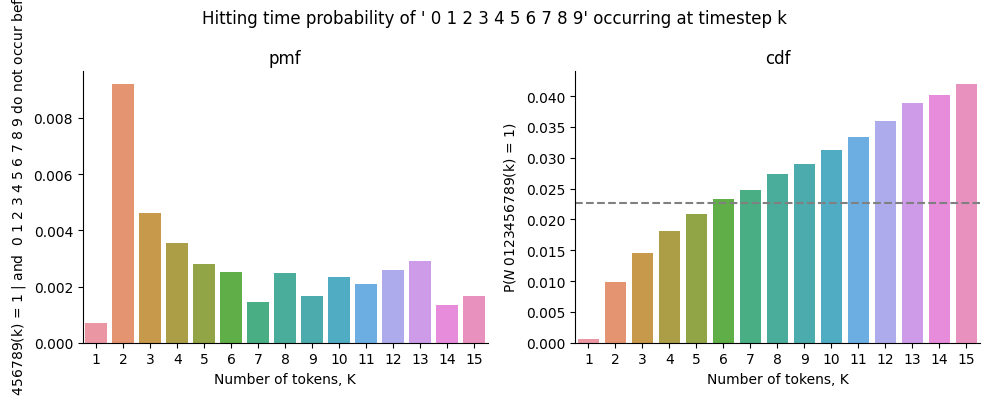

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
fig.suptitle(f"Hitting time probability of '{digits}' occurring at timestep k")
axes[0].set_title("pmf")
sns.barplot(x=np.arange(MAX_NUM_TOKENS)+1, y=hit_probs, ax=axes[0])
axes[0].set_xlabel("Number of tokens, K")
axes[0].set_ylabel(f"P(N(k) = 1 | and {digits} do not occur before k)")

sns.barplot(x=np.arange(MAX_NUM_TOKENS)+1, y=np.array(hit_probs).cumsum(), ax=axes[1])
axes[1].set_title("cdf")
axes[1].set_xlabel("Number of tokens, K")
axes[1].set_ylabel(f"P(N(k) = 1)")
axes[1].axhline(data_digits_prob, color="gray", ls="--")

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
query = {
        "bool": {
            "must": [{"match": {"text": "Paris"}}],
            "must_not": [{"match": {"text": "capital Capital"}}],
            "filter": [{"text"}]
        }
}

data = search(query=query)
data["hits"]["total"] # 2454489 - 2069382: 385107 (no filter - filter)